In [1]:
# importing libraries
%matplotlib inline
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (20,7)

In [16]:
df = pd.read_csv("testing_0_occurences2_sleep_accLog 2022-01-20 09_18_08.txt.csv",header=None)
# df = pd.read_csv("testing_0_occurence_Log 2022-01-20 19_21_12.txt.csv",header=None)

df.columns=['X','Y','Z','Magnitude']
df

,X,Y,Z,Magnitude
0,-24,-288,928,971.958847
1,-32,-328,944,999.871992
2,-64,-296,928,976.163921
3,-72,-280,952,994.931153
4,-56,-304,960,1008.539538
...,...,...,...,...
4020,264,16,-952,988.056678
4021,256,24,-944,978.390515
4022,264,24,-960,995.927708
4023,256,24,-944,978.390515


In [3]:
def plot(df,start,end,showx=False,showy=False,showz=False,showTotal=True):
    legend_lst=[]
    if(showx):
        sns.lineplot(y = 'X', x = df.index[start:end], data = df[start:end])
        legend_lst+='X'
    if(showy):
        sns.lineplot(y = 'Y', x = df.index[start:end], data = df[start:end])
        legend_lst+='Y'
    if(showz):
        sns.lineplot(y = 'Z', x = df.index[start:end], data = df[start:end])
        legend_lst+='Z'
    if(showTotal):
        sns.lineplot(y = 'Magnitude', x = df.index[start:end], data = df[start:end])
        legend_lst+='Magnitude'
    plt.legend(legend_lst)
    plt.ylabel("magnitude")
    plt.title("Accelerometer Plot from "+str(start)+" till "+str(end), fontsize = 15)
    plt.show()

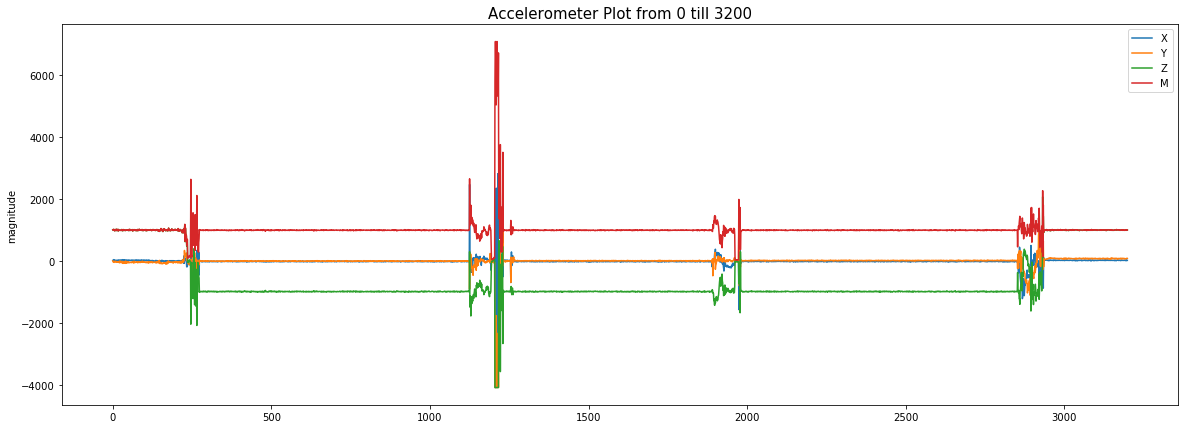

In [4]:
plot(df,0,3200,True,True,True,True)

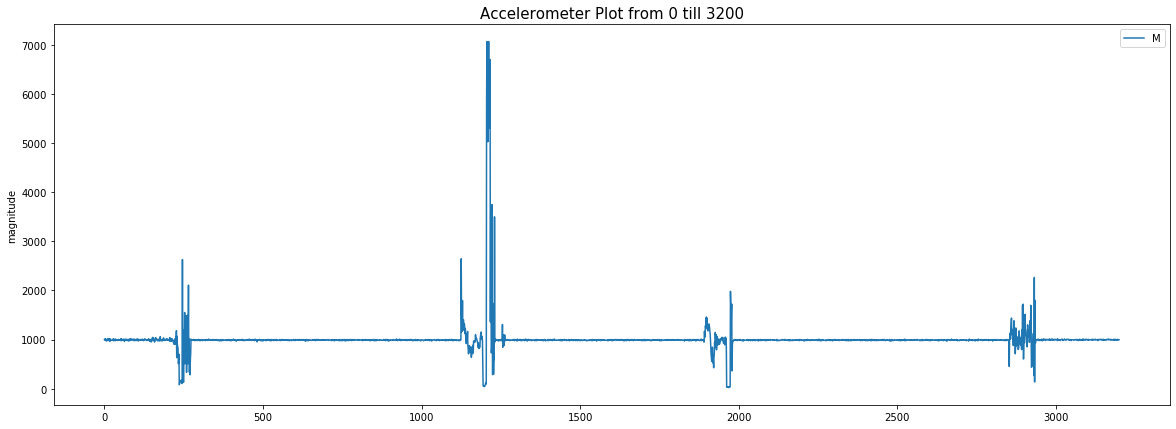

In [5]:
plot(df,0,3200)

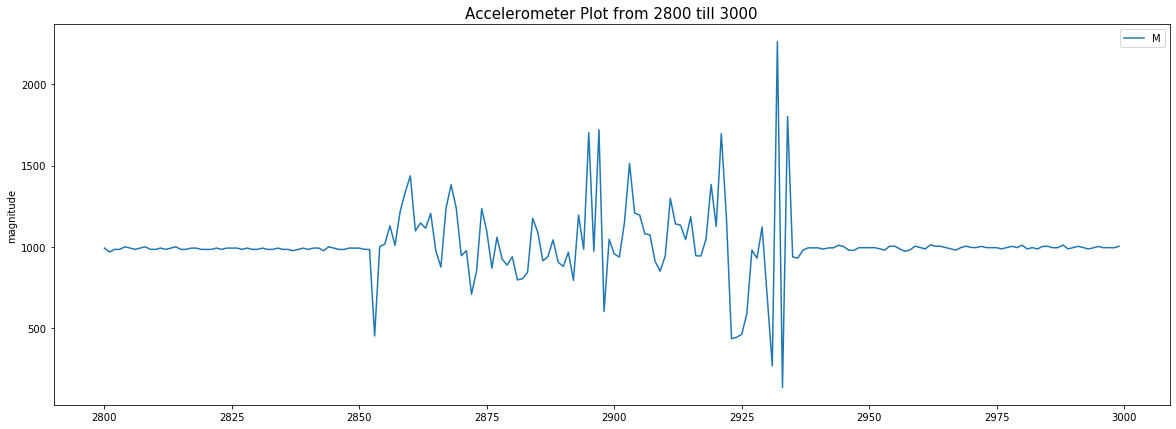

In [6]:
plot(df,2800,3000)

In [7]:
def extract_mean_max_min(data,start_time,win_size=50): #25Hz sampling rate
    avg=0
    min_mag=1e9
    max_mag=-1e9
    diff_max_min=0
    for i in range(start_time,start_time+win_size):
        if(i>=len(data)):
            break
        mag=(data.loc[i,'Magnitude'])
        avg+=mag
        min_mag=min(min_mag,mag)
        max_mag=max(max_mag,mag)
        diff_max_min=max(diff_max_min,max_mag-min_mag)
    return round(avg/win_size,2),min_mag,max_mag,diff_max_min
    

In [35]:
## FREE FALL DETECTION:
# def detect_free_fall(df,threshold_tending_0,impact_activity,inactivity)#takes data,
# prev=False
for i in range(0,df.index[-1],50):
        if((i>=250 and i<500) or (i>=1050 and i<1500) or (i>=2000 and i<2300) or (i>=2700 and i<=3000)):
                print(i,extract_mean_max_min(df,i,50))



250 (999.89, 965.1528376, 1040.676703, 75.52386540000009)
300 (848.89, 17.88854382, 1025.405286, 1007.5167421799999)
350 (938.78, 13.85640646, 6053.843738, 6039.98733154)
400 (994.77, 958.1983093, 1014.487063, 56.28875370000003)
450 (996.6, 981.2318788, 1006.157045, 24.925166200000035)
1050 (1115.46, 409.1747793, 2458.461307, 2049.2865277)
1100 (897.34, 96.66436779, 1462.294088, 1365.6297202100002)
1150 (993.96, 689.3475176, 1438.599319, 749.2518014)
1200 (985.16, 935.0764675, 1027.026777, 91.9503095)
1250 (988.5, 945.6933964, 1025.748507, 80.05511060000003)
1300 (709.35, 24.0, 5276.94457, 5252.94457)
1350 (985.63, 970.6410253, 1001.598722, 30.95769669999993)
1400 (985.01, 969.7174846, 1002.365203, 32.64771839999992)
1450 (984.57, 968.9582034, 1001.662618, 32.70441459999995)
2000 (984.61, 912.2806586, 1001.087409, 88.80675039999994)
2050 (1080.89, 207.8460969, 2600.504566, 2392.6584691000003)
2100 (978.8, 701.1305157, 1387.92507, 686.7945543)
2150 (783.61, 85.79044236, 3444.991727, 335

  in this file : testing_0_occurences2<br><br>
  1st peak-> 300 free fall<br>
               350 free fall, impact<br>
               400 inactivness<br><br>
    2nd peak-> 1300 free fall, impact<br>
               1350 inactivness<br><br>
    3rd peak-> 2150 free fall, impact<br>
               2200 inactiveness<br><br>
    4th peak-> 2950 free fall impact<br>
               3000 inactiveness<br><br>
  These are the trend that can be spotted, hence a minimum of 2 windows to a maximum of 3 are required to determine a Fall precisely<br>
#### All Possibilities:
case 1:fall in 1st window, impact in 1st, inactiveness in 2nd<br>
case 2:fall in 1st window, impact in 2nd, inactiveness in 3rd<br>
###### NOTE: Order will always be fall->impact->inactiveness: THEN FALL is CONFIRMED<br>
  Also, impact and inactiveness can never be in the same window since both are being evaluated through the variable   <br>maximum_diff_btwn_max_and_min_acc_magnitude, but thresholds for both are different<br>
  I'm coding this approach<br>

In [8]:
## FREE FALL DETECTION:
### V1
'''
def detect_free_fall(df,threshold_tending_0,impact_activity,inactivity,win_size=50,overlap_win=25):
    
    for i in range(0,df.index[-1]-win_size,overlap_win): 
        
        avg_mag,min_mag,max_mag,diff_max_min=extract_mean_max_min(df,i,win_size)

        if(min_mag<=threshold_tending_0):#fall detected
            print(i,"Free Fall detected")
            #case where impact and free fall in same window
            if(diff_max_min>=impact_activity):#min max diff
                print(i,"Impact also deteced-SAME WINDOW")
                if(extract_mean_max_min(df,i+win_size,win_size)[3]<=inactivity): #starts from next window till end
                    print("v1,Inactivness Detected: Fall confirmed")
                #other version only overlap window
                # 10 , 10, 5
                # 10+10 -- +5
                # 10+10 -- +10
                # 10+5 --- 10
                # 10+5 --- +5
                # over win
                if(extract_mean_max_min(df,i+overlap_win,overlap_win)[3]<=inactivity):#starts from mid window till mid end
                    print("v2,Inactivness Detected: Fall confirmed")
                if(extract_mean_max_min(df,i+win_size,overlap_win)[3]<=inactivity):#starts from next window till mid end
                    print("v3,Inactivness Detected: Fall confirmed")
                if(extract_mean_max_min(df,i+overlap_win,win_size)[3]<=inactivity):#starts from mid window till end
                    print("v4,Inactivness Detected: Fall confirmed")
            #Searching for Impact in next window
            elif(extract_mean_max_min(df,i+overlap_win,overlap_win)[3]>=impact_activity):#min max diff
                print(i,"Impact also deteced-NEXT WINDOW")
                if(extract_mean_max_min(df,i+win_size,win_size)[3]<=inactivity): #starts from next window till end
                    print("v1,Inactivness Detected: Fall confirmed")
                #other version only overlap window
                if(extract_mean_max_min(df,i+overlap_win,overlap_win)[3]<=inactivity):#starts from mid window till mid end
                    print("v2,Inactivness Detected: Fall confirmed")
                if(extract_mean_max_min(df,i+win_size,overlap_win)[3]<=inactivity):#starts from next window till mid end
                    print("v3,Inactivness Detected: Fall confirmed")
                if(extract_mean_max_min(df,i+overlap_win,win_size)[3]<=inactivity):#starts from mid window till end
                    print("v4,Inactivness Detected: Fall confirmed")

'''

In [43]:
## FREE FALL DETECTION: v2
#25 hz 1s , win size=50 2s  3->windows 6s, winsize10
def detect_free_fall(df,threshold_tending_0,impact_activity,inactivity,win_size=50,overlap_win=25):
    
    for i in range(0,df.index[-1]-win_size,overlap_win): 
        
        avg_mag,min_mag,max_mag,diff_max_min=extract_mean_max_min(df,i,win_size)

        if(min_mag<=threshold_tending_0):#fall detected
            # print(i,"Free Fall detected")
            #case where impact and free fall in same window
            if(diff_max_min>=impact_activity):#min max diff
                # print(i,"Impact also deteced-SAME WINDOW")
                temp_size=10 #window size for calculating average
                no_of_iterations = 15 #considering 2s [10*10==100 -> 25Hz in 1s]
                sum_diff=0
                for j in range(0,no_of_iterations+1):
                    sum_diff+=extract_mean_max_min(df,i+win_size+ (j*temp_size),temp_size)[3]
                avg_sum_diff = sum_diff/no_of_iterations
                if(avg_sum_diff<=inactivity):
                    print(i,"Inactivness, FALL CONFIRMED")
                else:
                    print(avg_sum_diff)
        
            #Searching for Impact in next window
            elif(extract_mean_max_min(df,i+overlap_win,overlap_win)[3]>=impact_activity):#min max diff
                # print(i,"Impact also deteced-NEXT WINDOW")
                temp_size=5 #window size for calculating average
                no_of_iterations = 30 #considering 2s [10*10==100 -> 25Hz in 1s]
                sum_diff=0
                for j in range(0,no_of_iterations+1):
                    sum_diff+=extract_mean_max_min(df,i+win_size+ (j*temp_size),temp_size)[3]
                avg_sum_diff = sum_diff/no_of_iterations
                if(avg_sum_diff<=inactivity):
                    print(i,"Inactivness, FALL CONFIRMED")
                else:
                    print(avg_sum_diff)

In [14]:
for k in range(0,11):
    print(k)

0
1
2
3
4
5
6
7
8
9
10


In [9]:
df.index[-1]

3249

In [41]:
detect_free_fall(df,95,3000,70)

180.87953362000002
350 Inactivness, FALL CONFIRMED
1300 Inactivness, FALL CONFIRMED
1325 Inactivness, FALL CONFIRMED
2150 Inactivness, FALL CONFIRMED
2175 Inactivness, FALL CONFIRMED
2950 Inactivness, FALL CONFIRMED
2975 Inactivness, FALL CONFIRMED


In [31]:
detect_free_fall(df,95,3000,145)

325 Inactivness, FALL CONFIRMED
350 Inactivness, FALL CONFIRMED
1300 Inactivness, FALL CONFIRMED
1325 Inactivness, FALL CONFIRMED
2150 Inactivness, FALL CONFIRMED
2175 Inactivness, FALL CONFIRMED
2950 Inactivness, FALL CONFIRMED
2975 Inactivness, FALL CONFIRMED


In [32]:
detect_free_fall(df,95,3000,70)

98.51489807333334
350 Inactivness, FALL CONFIRMED
1300 Inactivness, FALL CONFIRMED
1325 Inactivness, FALL CONFIRMED
2150 Inactivness, FALL CONFIRMED
2175 Inactivness, FALL CONFIRMED
2950 Inactivness, FALL CONFIRMED
2975 Inactivness, FALL CONFIRMED


In [17]:
detect_free_fall(df,95,3000,70)

300 Free Fall detected
325 Free Fall detected
325 Impact also deteced-SAME WINDOW
350 Free Fall detected
350 Impact also deteced-SAME WINDOW
Inactivness, FALL CONFIRMED
1300 Free Fall detected
1300 Impact also deteced-SAME WINDOW
Inactivness, FALL CONFIRMED
1325 Free Fall detected
1325 Impact also deteced-SAME WINDOW
Inactivness, FALL CONFIRMED
2150 Free Fall detected
2150 Impact also deteced-SAME WINDOW
Inactivness, FALL CONFIRMED
2175 Free Fall detected
2175 Impact also deteced-SAME WINDOW
Inactivness, FALL CONFIRMED
2925 Free Fall detected
2950 Free Fall detected
2950 Impact also deteced-SAME WINDOW
Inactivness, FALL CONFIRMED
2975 Free Fall detected
2975 Impact also deteced-SAME WINDOW
Inactivness, FALL CONFIRMED


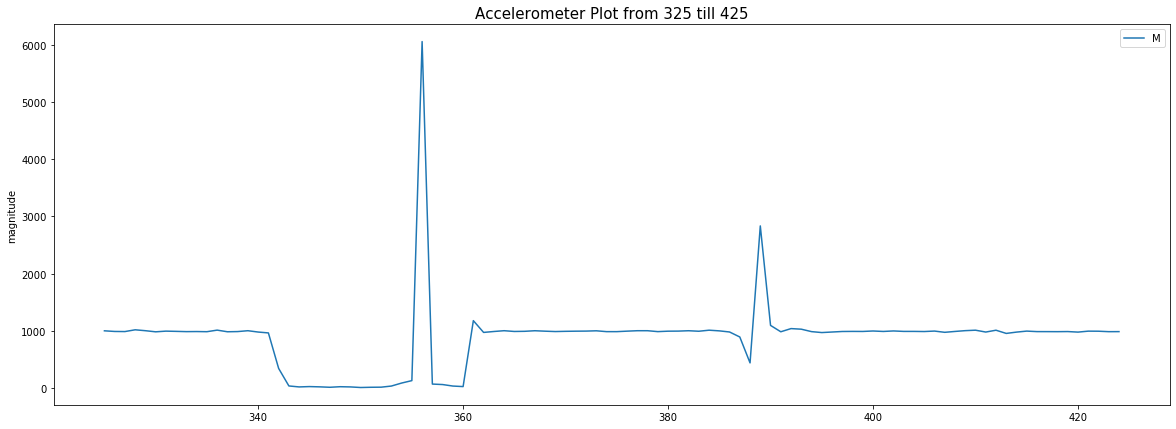

In [41]:
plot(df,325,425)

In [ ]:
350 Free Fall detected
350 Impact also deteced-SAME WINDOW
v1,Inactivness Detected: Fall confirmed
v3,Inactivness Detected: Fall confirmed
### CORRECT

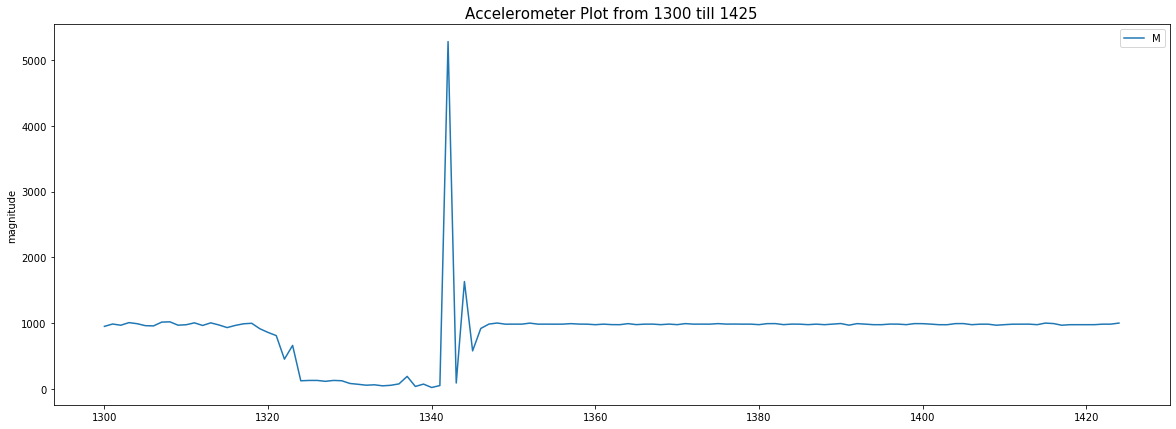

In [42]:
plot(df,1300,1425)

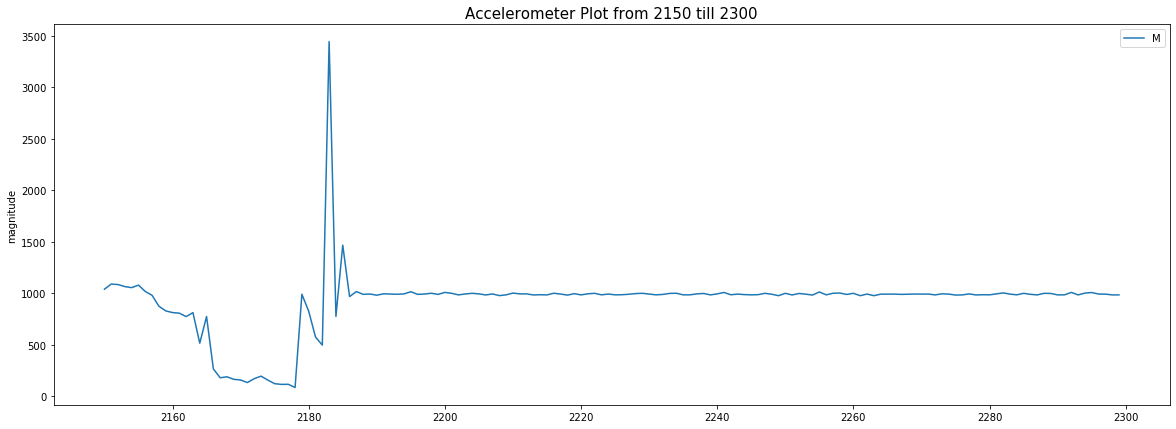

In [43]:
plot(df,2150,2300)

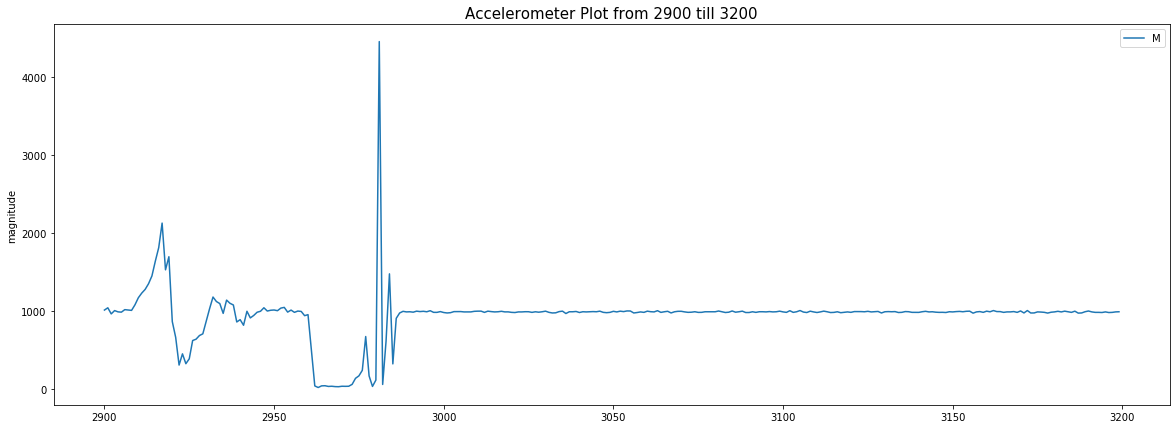

In [45]:
plot(df,2900,3200)

In [18]:
df1 = pd.read_csv("testing_0_occurence_Log 2022-01-20 19_21_12.txt.csv",header=None)
df1.columns=['X','Y','Z','Magnitude']

In [38]:
detect_free_fall(df,95,2000,200)

325 Inactivness, FALL CONFIRMED
350 Inactivness, FALL CONFIRMED
1300 Inactivness, FALL CONFIRMED
1325 Inactivness, FALL CONFIRMED
2150 Inactivness, FALL CONFIRMED
2175 Inactivness, FALL CONFIRMED
2950 Inactivness, FALL CONFIRMED
2975 Inactivness, FALL CONFIRMED


In [37]:
detect_free_fall(df1,95,2000,200)

214.80884100333333
225 Inactivness, FALL CONFIRMED
1175 Inactivness, FALL CONFIRMED
1200 Inactivness, FALL CONFIRMED


In [42]:
detect_free_fall(df1,95,2000,200)

279.82006506000005
225 Inactivness, FALL CONFIRMED
266.45392010666666
1200 Inactivness, FALL CONFIRMED


In [34]:
detect_free_fall(df1,95,2000,300)

200 Inactivness, FALL CONFIRMED
225 Inactivness, FALL CONFIRMED
1175 Inactivness, FALL CONFIRMED
1200 Inactivness, FALL CONFIRMED


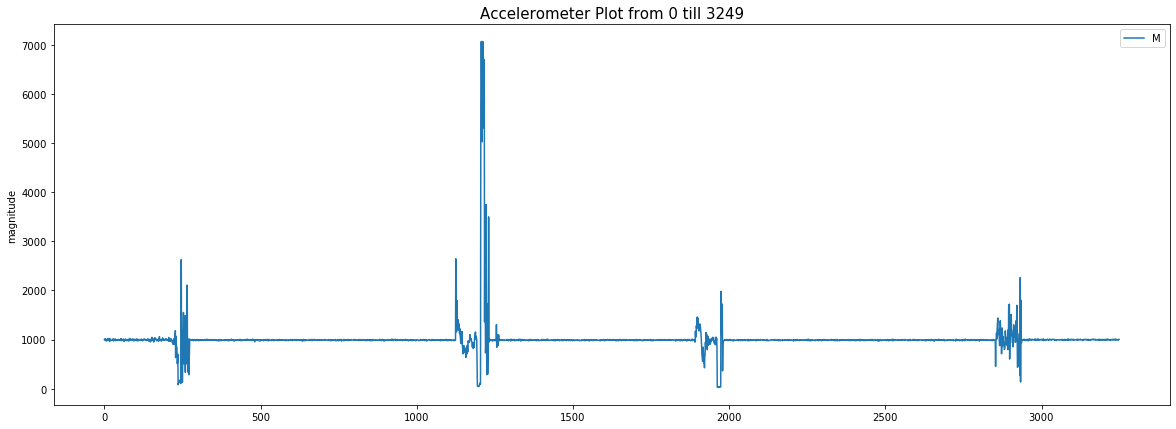

In [12]:
plot(df1,0,df1.index[-1])

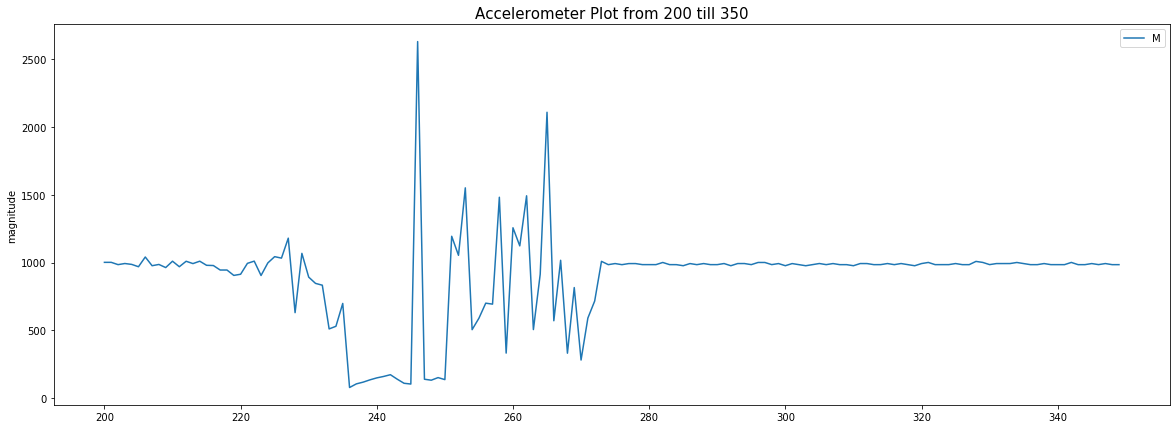

In [13]:
plot(df1,200,350)

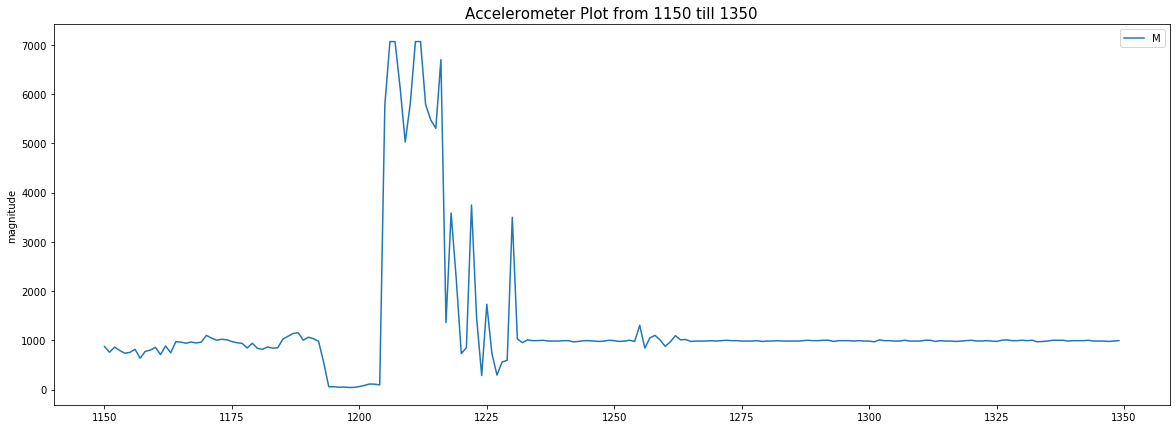

In [54]:
plot(df1,1150,1350)

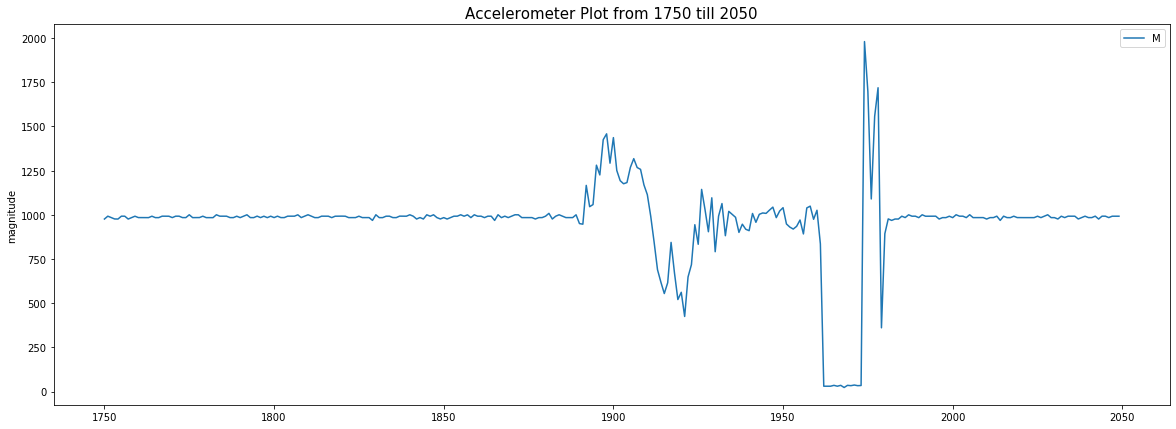

In [55]:
plot(df1,1750,2050)

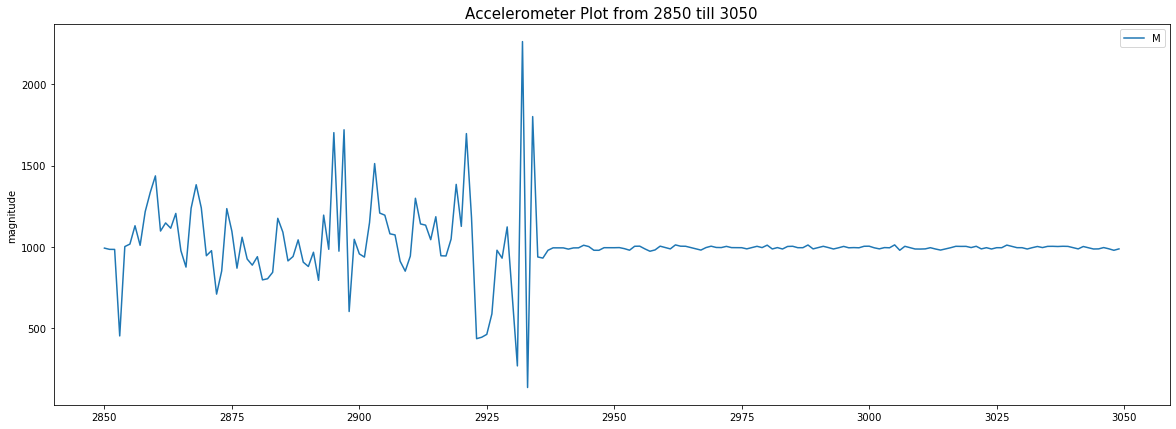

In [56]:
plot(df1,2850,3050)

In [51]:
for i in range(0,df1.index[-1],50):
        if((i>=200 and i<350) or (i>=1100 and i<1350) or (i>=1900 and i<2100) or (i>=2700 and i<=3000)):
                print(i,extract_mean_max_min(df1,i,50))

200 (760.96, 78.79086241, 2628.130895, 2549.3400325899997)
250 (933.1, 136.9379421, 2107.206682, 1970.2687399000001)
300 (987.92, 976.1311387, 1008.06349, 31.93235130000005)
1100 (1096.21, 707.8530921, 2643.984871, 1936.1317789)
1150 (801.82, 40.79215611, 1152.944058, 1112.15190189)
1200 (2304.2, 60.39867548, 7066.767295, 7006.36861952)
1250 (995.66, 841.294241, 1304.441643, 463.14740200000006)
1300 (989.18, 968.1322224, 1008.285674, 40.153451599999926)
1900 (955.33, 424.7540465, 1436.996868, 1012.2428215)
1950 (799.78, 22.627417, 1980.545379, 1957.917962)
2000 (987.12, 968.4296567, 1000.511869, 32.08221230000004)
2050 (987.75, 976.1639207, 1000.543852, 24.379931300000067)
2700 (987.29, 968.4296567, 1008.253936, 39.824279299999944)
2750 (990.01, 976.1639207, 1008.31741, 32.15348930000005)
2800 (988.14, 968.2644267, 1000.319949, 32.05552230000001)
2850 (1034.06, 452.1946484, 1719.851156, 1267.6565076)
2900 (1016.53, 135.0555441, 2262.175944, 2127.1203999)
2950 (995.52, 972.8802598, 1011